In [86]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
import random
import tensorflow as tf
from tensorflow.math import confusion_matrix
import keras
import seaborn as sns

In [73]:
train_images = []
test_images = []
train_labels = []
test_labels = []
current_map = "idc_regular"
patient = [file for file in os.listdir(current_map)]

In [74]:
counter = 0
for person in patient:
    counter += 1
    pos_path = f"{current_map}/{person}/1"
    neg_path = f"{current_map}/{person}/0"
    if counter == 5:
        pos_files = os.listdir(pos_path)
        length_pos = len(pos_files)
        for ind in random.sample(range(0, length_pos), int(length_pos/4)):
            saved = np.asarray(Image.open(f"{pos_path}/{pos_files[ind]}"))
            if saved.shape == (50, 50, 3):
                test_images.append(saved)
                test_labels.append(1)
        neg_files = os.listdir(neg_path)
        length_neg = len(neg_files)
        for ind in random.sample(range(0, length_neg), int(length_neg/4)):
            saved = np.asarray(Image.open(f"{neg_path}/{neg_files[ind]}"))
            if saved.shape == (50, 50, 3):
                test_images.append(saved)
                test_labels.append(0)
        counter = 0
    else:
        pos_files = os.listdir(pos_path)
        length_pos = len(pos_files)
        for ind in random.sample(range(0, length_pos), int(length_pos/4)):
            saved = np.asarray(Image.open(f"{pos_path}/{pos_files[ind]}"))
            if saved.shape == (50, 50, 3):
                train_images.append(saved)
                train_labels.append(1)
        neg_files = os.listdir(neg_path)
        length_neg = len(neg_files)
        for ind in random.sample(range(0, length_neg), int(length_neg/4)):
            saved = np.asarray(Image.open(f"{neg_path}/{neg_files[ind]}"))
            if saved.shape == (50, 50, 3):
                train_images.append(saved)
                train_labels.append(0)

train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [94]:
test_images.shape

(14786, 50, 50, 3)

In [99]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(50, 50, 3)),    # images are 28 x 28
    keras.layers.Dense(128, activation='relu'), # Could be lower for my computer
    keras.layers.Dense(10, activation="softmax") # Number between the 0 and 1
])

model.compile(optimizer=keras.optimizers.Adam(0.001),
              loss=keras.losses.SparseCategoricalCrossentropy(), # from_logits=True
              metrics=[keras.metrics.SparseCategoricalAccuracy()])

c:\Users\gielb\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [100]:
hist = model.fit(train_images, train_labels, epochs=6)

Epoch 1/6
1682/1682 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - loss: 187.3179 - sparse_categorical_accuracy: 0.6865
Epoch 2/6
1682/1682 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - loss: 63.0905 - sparse_categorical_accuracy: 0.7199
Epoch 3/6
1682/1682 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - loss: 9.8858 - sparse_categorical_accuracy: 0.7241
Epoch 4/6
1682/1682 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - loss: 1.0282 - sparse_categorical_accuracy: 0.7895
Epoch 5/6
1682/1682 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - loss: 0.5937 - sparse_categorical_accuracy: 0.7830
Epoch 6/6
1682/1682 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - loss: 0.5019 - sparse_categorical_accuracy: 0.7798


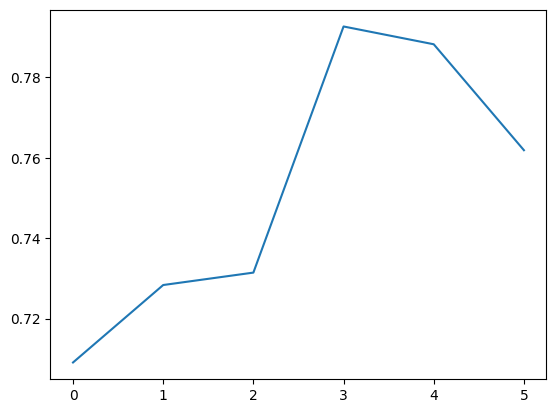

In [101]:
plt.plot(hist.history['sparse_categorical_accuracy'])

463/463 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


<Axes: >

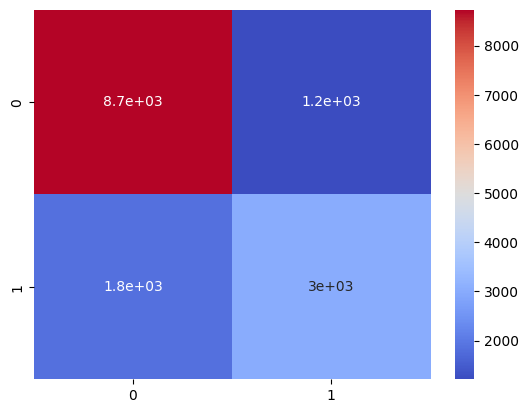

In [102]:
y_pred = model.predict(test_images)
df = np.asarray(confusion_matrix(np.argmax(y_pred, axis=1), test_labels))
sns.heatmap(df, annot=True, cmap='coolwarm')

Uit de confusionmatrix en accuracy plot blijkt dat het model het beste scoort bij de 5/6 epochs. Bij 5 epochs is de accuracy hoger, alleen bij 6 epochs is het aantal true positive voorspellingen hoger. <br>
Helaas blijft het aantal false negatives vrij hoog, ongeacht het aantal epochs. Dit betekend dat het model aangeeft dat er geen sprake van een tumor is, terwijl dit in werkelijkheid wel zo is. De reden hiervoor is het gebruik van een hoger aantal negatieve afbeeldingen bij het trainen van het model (zoals in de EDA te zien is). Hierdoor zal het aantal false negative voorspellingen altijd hoog blijven. <br>
False positives zijn minder erg, aangezien dan een patient later nog kan horen dat hij geen kanker heeft. Hierdoor maken deze niet al te veel uit,waardoor deze niet direct worden meegenomen in het maken van een keuze voor het 'beste' model. <br>
Door de betere voorspellingen voor tumoren bij 6 epochs, ondanks de lagere accuracy, wordt ervoor gekozen om 6 epochs te gebruiken.